In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import shapely.geometry as shg           # for finding intersection of 2 lines
from shapely.geometry import LineString  # for finding intersection of 2 lines
from itertools import chain   # chain two ranges together
import sys

#location of the csv file
location = "./paper_tests/wl2_13day.csv"
#location of the baseline csv file
baseline = "./paper_tests/baseline_wl2_13day.csv"

#words to the title of each figure
title1="baseline vs"
title2="less reliable memory"

#used for naming the figure's png files.
figGroup="paper_reg_change_1_"

#figure size
figSizeWidth=20
figSizeHeight=10

In [47]:
#read in the baseline csv file
df_baseline = pd.read_csv(baseline,sep=",",header=0)

#save the baseline makespan
g = df_baseline["makespan_sec"].values[0]

#save the NMTBF of the baseline
baselineNMTBF=df_baseline["NMTBF"].values[0]
baselineNodes = df_baseline['nodes'].values[0]

#read in the makespan data
df = pd.read_csv(location,sep=",",header=0)
df['factor'] = baselineNMTBF / np.float64(df['NMTBF'])
df['factor'] = df['factor'].astype(int)
df['normalized_makespan'] = np.float64(df['makespan_sec']) / g
df['normalized_nodes'] = np.float64(df['nodes']) / baselineNodes

# we are only interested in 32x for this plot
df = df.query("factor == 32")
df = df.sort_values(by="nodes").reset_index(drop=True)

x = [str(x) for x in df['nodes']]

In [48]:
df

Unnamed: 0  Unnamed: 0.1  nodes         SMTBF       NMTBF  \
0                0             0   1490  36241.610738  54000000.0   
1                0             0   1490  36241.610738  54000000.0   
2                0             0   1490  36241.610738  54000000.0   
3                0             0   1490  36241.610738  54000000.0   
4                0             0   1490  36241.610738  54000000.0   
...            ...           ...    ...           ...         ...   
104985           0             0   1566  34482.758621  54000000.0   
104986           0             0   1566  34482.758621  54000000.0   
104987           0             0   1566  34482.758621  54000000.0   
104988           0             0   1566  34482.758621  54000000.0   
104989           0             0   1566  34482.758621  54000000.0   

        makespan_sec      makespan_dhms       AAE  checkpointed_num  \
0       5.442681e+06  62 days, 23:51:20  0.925964                11   
1       5.363538e+06   62 days, 1:52:17  0.919051                14   
2       5.904757e+06   68 days, 8:12:37  0.911774                16   
3       5.691118e+06  65 days, 20:51:57  0.922813                11   
4       5.254362e+06  60 days, 19:32:41  0.916780                11   
...              ...                ...       ...               ...   
104985  4.344639e+06   50 days, 6:50:38  0.932310                14   
104986  4.318163e+06  49 days, 23:29:22  0.919658                16   
104987  4.233541e+06  48 days, 23:59:01  0.927472                13   
104988  4.653713e+06  53 days, 20:41:52  0.916119                17   
104989  4.272004e+06  49 days, 10:40:04  0.926633                13   

        percent_checkpointed       avg_tat       avg_tat_dhms      run  \
0                   0.000367  2.385956e+06  27 days, 14:45:56  Run_372   
1                   0.000467  2.406183e+06  27 days, 20:23:03  Run_343   
2                   0.000533  2.706115e+06   31 days, 7:41:55  Run_342   
3                   0.000367  2.625024e+06   30 days, 9:10:23  Run_341   
4                   0.000367  2.384833e+06  27 days, 14:27:13  Run_340   
...                      ...           ...                ...      ...   
104985              0.000467  1.949704e+06  22 days, 13:35:04  Run_663   
104986              0.000533  1.956364e+06  22 days, 15:26:04  Run_662   
104987              0.000433  1.864956e+06  21 days, 14:02:35  Run_661   
104988              0.000567  2.105701e+06   24 days, 8:55:01  Run_674   
104989              0.000433  1.906815e+06   22 days, 1:40:15  Run_130   

                  job  factor  normalized_makespan  normalized_nodes  
0        experiment_1      32             1.209903          1.000000  
1        experiment_1      32             1.192310          1.000000  
2        experiment_1      32             1.312623          1.000000  
3        experiment_1      32             1.265131          1.000000  
4        experiment_1      32             1.168040          1.000000  
...               ...     ...                  ...               ...  
104985  experiment_21      32             0.965810          1.051007  
104986  experiment_21      32             0.959924          1.051007  
104987  experiment_21      32             0.941113          1.051007  
104988  experiment_21      32             1.034516          1.051007  
104989  experiment_21      32             0.949663          1.051007  

[104990 rows x 17 columns]

In [81]:
min(df['normalized_nodes'])

1.0

In [82]:
max(df['normalized_nodes'])

1.051006711409396

In [155]:
df.query("normalized_nodes == 1")['normalized_makespan'].mean()

1.2170215348948772

In [160]:
# some helper code to find intersection of columns from the dataframe
def find_intersection_of_two_curves(x, y1, y2, deg):
    y1_fit = np.polyfit(x, y1, deg)
    y1_func = np.poly1d(y1_fit)

    y2_fit = np.polyfit(x, y2, deg)
    y2_func = np.poly1d(y2_fit)

    from scipy.optimize import fsolve
    def findIntersection(fun1,fun2,x0):
        return fsolve(lambda x : fun1(x) - fun2(x), x0)

    result = findIntersection(y1_func, y2_func, 0.0)
    return (result[0],y1_func(result[0]))

In [172]:
meandf = pd.DataFrame(df.groupby('normalized_nodes')['normalized_makespan'].mean()).reset_index()
meandf['baseline'] = 1.0
display(meandf.head())

normalized_nodes  normalized_makespan  baseline
0          1.000000             1.217022       1.0
1          1.000671             1.200795       1.0
2          1.001342             1.183765       1.0
3          1.002013             1.175928       1.0
4          1.002685             1.162176       1.0

In [195]:
# this is the intersection
intersection = find_intersection_of_two_curves(meandf['normalized_nodes'], meandf['normalized_makespan'], meandf['baseline'], 5.0)

In [273]:

sns.set(rc={'figure.figsize':(20,8)})
sns.set_style("whitegrid")


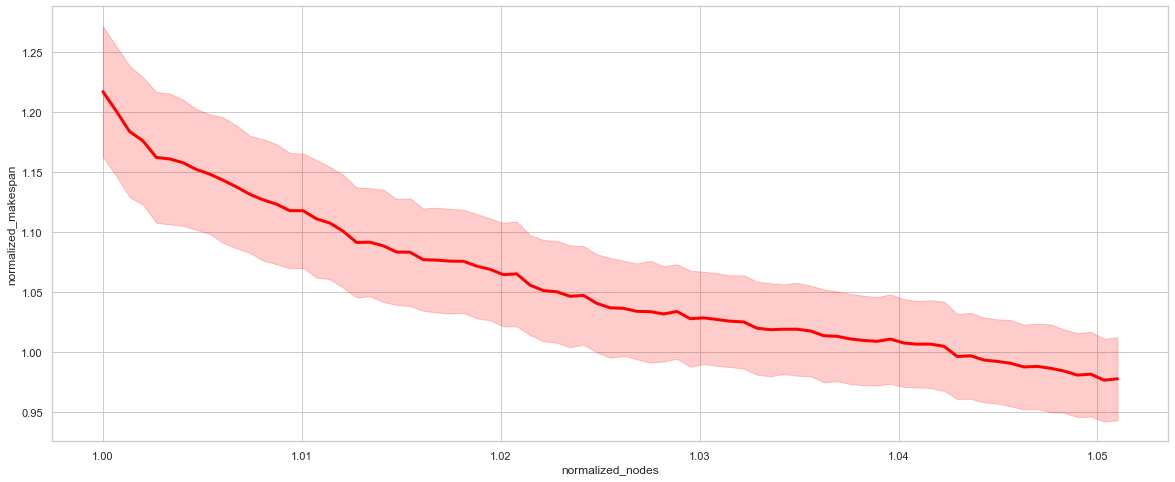

In [274]:
myplot = sns.lineplot(x="normalized_nodes", y="normalized_makespan", data=df, 
                      color='red', 
                      err_style='band',
                      #estimator=np.mean,
                      #err_style="bars",
                      #ci = "sd",
                      ci = "sd",
                      lw = 3
                    )

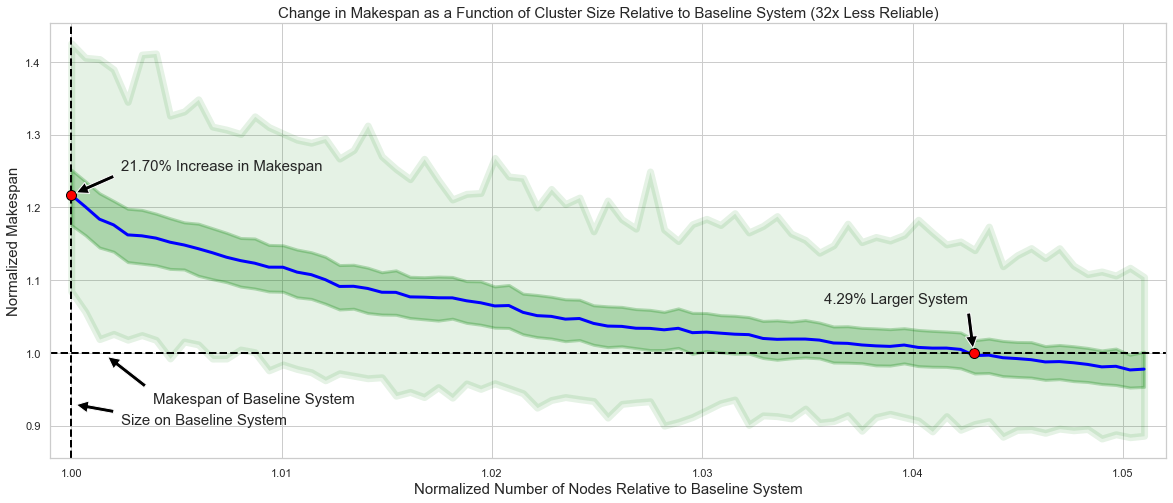

In [275]:
myplot = sns.lineplot(x="normalized_nodes", y="normalized_makespan", data=df, 
                      color='blue', 
                      err_style='band',
                      #estimator=np.mean,
                      #err_style="bars",
                      #ci = "sd",
                      #ci = "sd",
                      ci = None,
                      lw = 3
                     )

bounds = df.groupby('normalized_nodes')['normalized_makespan'].quantile((0,1.0)).unstack()
myplot.fill_between(x=bounds.index,y1=bounds.iloc[:,0],y2=bounds.iloc[:,1],alpha=0.1, color='green', lw=7)

bounds = df.groupby('normalized_nodes')['normalized_makespan'].quantile((0.25,0.75)).unstack()
myplot.fill_between(x=bounds.index,y1=bounds.iloc[:,0],y2=bounds.iloc[:,1],alpha=0.25, color='green', lw=3)

myplot.axhline(1, color = 'black', lw=2, ls='--')
myplot.axvline(1, color = 'black', lw=2, ls='--')

y_intersection = df.query("normalized_nodes == 1")['normalized_makespan'].mean()

# y intersection dot
myplot.plot(1.0, y_intersection, 'o', mec='black', color='red', ms=10, linewidth=5)

# y intersection arrow
y_text = (y_intersection - 1.0) * 100.0
myplot.annotate(text=f"{y_text:.2f}% Increase in Makespan", 
            xy=(1.0, y_intersection), 
            xycoords='data', 
            xytext=(50, 25), 
            fontsize=15,
            textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.1)
           )

# baseline / x intersection dot
myplot.plot(intersection[0], intersection[1], 'o', mec='black', color='red', ms=10, linewidth=5)

# baseline / x intersection arrow
x_text = (intersection[0] - 1.0) * 100.0
myplot.annotate(text=f"{x_text:.2f}% Larger System", 
            xy=(intersection[0], intersection[1]), 
            xycoords='data', 
            xytext=(-150, 50), 
            fontsize=15,
            textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.1)
           )

# baseline arrow
myplot.annotate(text="Makespan of Baseline System", 
            xy=(1.0015, 1.0), 
            xycoords='data', 
            xytext=(50, -50), 
            fontsize=15,
            textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.1)
           )

# baseline system arrow
myplot.annotate(text="Size on Baseline System", 
            xy=(1.0, 0.93), 
            xycoords='data', 
            xytext=(50, -20), 
            fontsize=15,
            textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.1)
           )

plt.xlim(min(df['normalized_nodes']) * 0.999, max(df['normalized_nodes']) * 1.001)

plt.ylabel("Normalized Makespan", fontsize=15)
plt.xlabel("Normalized Number of Nodes Relative to Baseline System", fontsize=15)
plt.title("Change in Makespan as a Function of Cluster Size Relative to Baseline System (32x Less Reliable)", fontsize=15)    


plt.savefig(f"32x_lines_with_IQR.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.savefig(f"32x_lines_with_IQR.png", bbox_inches = 'tight', pad_inches = 0)

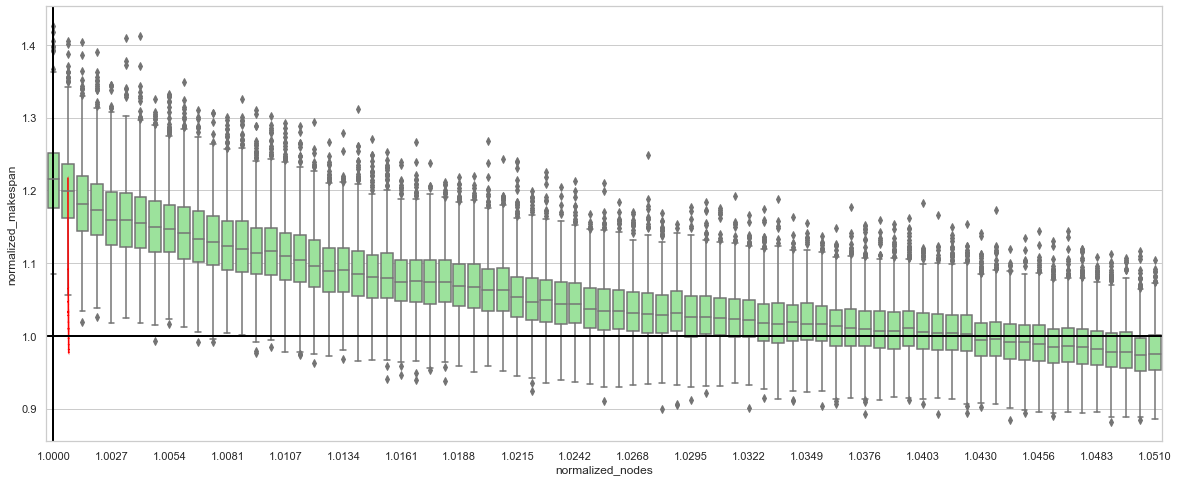

In [115]:
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style("whitegrid")
myplot = sns.boxplot(x="normalized_nodes", y="normalized_makespan", data=df,
                    color='lightgreen'
                    )#, order=myOrder)

myplot.axhline(1, color = 'black', lw=2, ls='-')
myplot.axvline(0, color = 'black', lw=2, ls='-')
#myplot.axvline(max(df['normalized_nodes']), color = 'red', lw=2, ls='-')

medians = df.groupby(['normalized_nodes'])['normalized_makespan'].median()

new_ticks = [i.get_text() for i in myplot.get_xticklabels()]
plot_every_x_nodes = 4
plt.xticks(range(0, len(new_ticks), plot_every_x_nodes), new_ticks[::plot_every_x_nodes]);
myplot.set_xticklabels(['{:.4f}'.format(float(t.get_text())) for t in myplot.get_xticklabels()]);


In [99]:
print(boxplots[0].x0, boxplots[0].y0, boxplots[0].x1, boxplots[0].y1)

181.44935064935066 305.28005606645354 193.04415584415585 360.659974212503


In [75]:
m = df.groupby('nodes')['normalized_makespan'].mean()
myBaseline=[g]*len(m.index)
first_line = LineString(np.column_stack((m.index,m.values)))
second_line = LineString(np.column_stack((m.index,myBaseline )))
intersection = second_line.intersection(first_line)

In [77]:
type(intersection)

shapely.geometry.linestring.LineString

In [107]:
df

Unnamed: 0  Unnamed: 0.1  nodes         SMTBF       NMTBF  \
0                0             0   1490  36241.610738  54000000.0   
1                0             0   1490  36241.610738  54000000.0   
2                0             0   1490  36241.610738  54000000.0   
3                0             0   1490  36241.610738  54000000.0   
4                0             0   1490  36241.610738  54000000.0   
...            ...           ...    ...           ...         ...   
104985           0             0   1566  34482.758621  54000000.0   
104986           0             0   1566  34482.758621  54000000.0   
104987           0             0   1566  34482.758621  54000000.0   
104988           0             0   1566  34482.758621  54000000.0   
104989           0             0   1566  34482.758621  54000000.0   

        makespan_sec      makespan_dhms       AAE  checkpointed_num  \
0       5.442681e+06  62 days, 23:51:20  0.925964                11   
1       5.363538e+06   62 days, 1:52:17  0.919051                14   
2       5.904757e+06   68 days, 8:12:37  0.911774                16   
3       5.691118e+06  65 days, 20:51:57  0.922813                11   
4       5.254362e+06  60 days, 19:32:41  0.916780                11   
...              ...                ...       ...               ...   
104985  4.344639e+06   50 days, 6:50:38  0.932310                14   
104986  4.318163e+06  49 days, 23:29:22  0.919658                16   
104987  4.233541e+06  48 days, 23:59:01  0.927472                13   
104988  4.653713e+06  53 days, 20:41:52  0.916119                17   
104989  4.272004e+06  49 days, 10:40:04  0.926633                13   

        percent_checkpointed       avg_tat       avg_tat_dhms      run  \
0                   0.000367  2.385956e+06  27 days, 14:45:56  Run_372   
1                   0.000467  2.406183e+06  27 days, 20:23:03  Run_343   
2                   0.000533  2.706115e+06   31 days, 7:41:55  Run_342   
3                   0.000367  2.625024e+06   30 days, 9:10:23  Run_341   
4                   0.000367  2.384833e+06  27 days, 14:27:13  Run_340   
...                      ...           ...                ...      ...   
104985              0.000467  1.949704e+06  22 days, 13:35:04  Run_663   
104986              0.000533  1.956364e+06  22 days, 15:26:04  Run_662   
104987              0.000433  1.864956e+06  21 days, 14:02:35  Run_661   
104988              0.000567  2.105701e+06   24 days, 8:55:01  Run_674   
104989              0.000433  1.906815e+06   22 days, 1:40:15  Run_130   

                  job  factor  normalized_makespan  normalized_nodes  
0        experiment_1      32             1.209903          1.000000  
1        experiment_1      32             1.192310          1.000000  
2        experiment_1      32             1.312623          1.000000  
3        experiment_1      32             1.265131          1.000000  
4        experiment_1      32             1.168040          1.000000  
...               ...     ...                  ...               ...  
104985  experiment_21      32             0.965810          1.051007  
104986  experiment_21      32             0.959924          1.051007  
104987  experiment_21      32             0.941113          1.051007  
104988  experiment_21      32             1.034516          1.051007  
104989  experiment_21      32             0.949663          1.051007  

[104990 rows x 17 columns]

/Users/ndebard/python_virtualenv_ndebard/lib/python3.8/site-packages/seaborn/categorical.py:1733: UserWarning: You passed a edgecolor/edgecolors ([(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901

AttributeError: 'AxesSubplot' object has no attribute 'map'

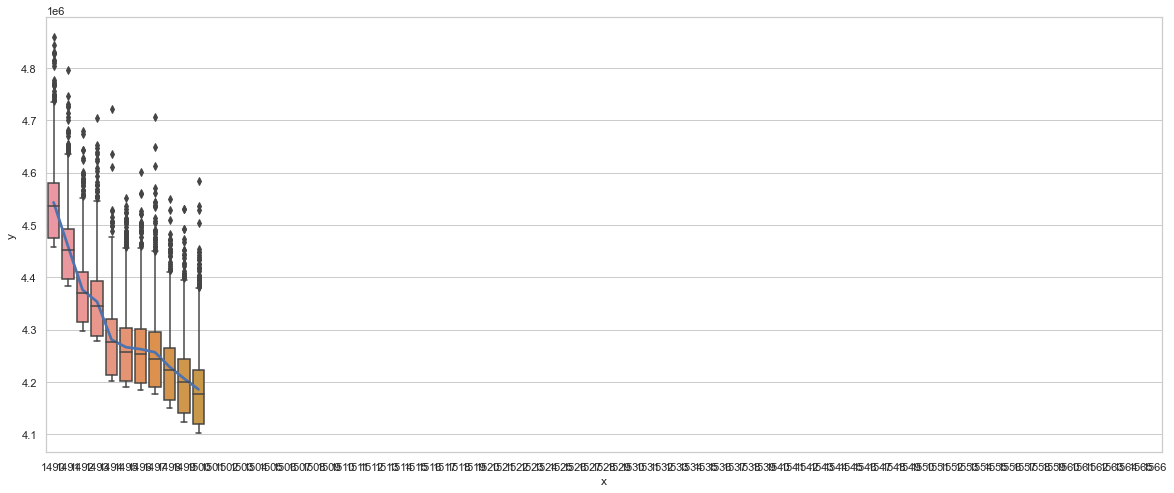

In [22]:
#this function rounds to the base.  ex: x=20.5 base=.5  return 20.5
#                                       x=20.3 base=.5  return 20.5
#                                       x=20.1 base=.5  return 20.0
def myround(x, base=1.0):
    return base * round(x/base)

#this function is used to check if we need a new figure (currently there are 3 subplots per figure)
#so if we are on our 4th plot we need a new figure and we need to save the old one.
def checkFig(*,row,figCount,fig=None,axs=None,rows=subplots):
    return row,figCount,fig,axs
    
    #if this is our first subplot in the figure we need a new figure
    if fig==None:
        fig,axs = plt.subplots(rows,1,figsize=(figSizeWidth,figSizeHeight*rows))
    #if the finished row equals the amount of subplots that are in a figure
    #then we need a new figure.  Save the figure, make a new one, and increase the figCount
    if row==subplots:
        fig.savefig(figGroup+"fig"+str(figCount)+".png",dpi=300)
        fig.savefig(figGroup+"fig"+str(figCount)+".pdf",dpi=300)
        fig,axs = plt.subplots(rows,1,figsize=(figSizeWidth,figSizeHeight*rows))
        figCount+=1
        return 0,figCount,fig,axs
    return row,figCount,fig,axs




#read in the baseline csv file
df_baseline = pd.read_csv(baseline,sep=",",header=0)

#save the baseline makespan
g = df_baseline["makespan_sec"].values[0]

#save the NMTBF of the baseline
baselineNMTBF=df_baseline["NMTBF"].values[0]

#read in the makespan data
df = pd.read_csv(location,sep=",",header=0)

#group the makespan data by NMTBF
groups = df.groupby(["NMTBF"])
#get the keys that are in the groups
myKeys=[key for key, _ in groups]
#sort the keys in reverse order
myKeys.sort(reverse=True)

#when you return df.groupby it has a weird datatype
#get the groups into a more functional dictionary
myGroups={}
for i in groups.groups.keys():
    myGroups[i]=groups.get_group(i)


# we want our graphs to look uniform so get the largest and smallest y values and the same with
# the x values so we can set each graph to have the same scale
largestY=0
smallestY=0
largestX=0
smallestX=0
for i in myKeys:
    myData=myGroups[i]
    theMaxY = myData["makespan_sec"].max()
    theMaxX = myData["nodes"].max()
    if theMaxY > largestY:
        largestY=theMaxY
    if theMaxX > largestX:
        largestX=theMaxX
    theMinY = myData["makespan_sec"].min()
    theMinX = myData["nodes"].min()
    if smallestY==0 or theMinY < smallestY:
        smallestY = theMinY
    if smallestX==0 or theMinX < smallestX:
        smallestX = theMinX


meanYPlots=[]
meanXPlots=[]
meanXPlotsFlt=[]
myXstr=[str(x) for x in list(np.arange(smallestX,largestX+1,1))]
myOrder=[str(x) for x in range(smallestX,largestX+1)]
myXflt=[np.float64(x) for x in list(np.arange(smallestX,largestX+1,1))]
intersections=[]
levels=[]
figCount=1
row=0
row,figCount,fig,axs=checkFig(row=row,figCount=figCount)
#fig.suptitle('Comparing Regular Grizzly Workloads With Increasingly Worse Memory Failures', y=.98,fontsize=28)


for i in myKeys:
    row,figCount,fig,axs=checkFig(row=row,figCount=figCount,fig=fig,axs=axs)
    #put key in terms of 2x, 4x ...etc
    level = baselineNMTBF/np.float64(i)
    levels.append(level)
    myData = myGroups[i]
    myData = myData.sort_values(by="nodes").reset_index(drop=True)
    #get intersection
    m=myData.groupby("nodes")["makespan_sec"].mean()
    meanYPlots.append(m)
    meanXPlots.append(m.index)
    myBaseline=[g]*len(m.index)
    first_line = LineString(np.column_stack((m.index,m.values)))
    second_line = LineString(np.column_stack((m.index,myBaseline )))
    intersection = second_line.intersection(first_line)
    if intersection:
        if type(intersection)==shg.point.Point:
            intersections.append(intersection.xy)
        else:
            intersections.append(LineString(intersection).xy)
    
    
    
    x=[str(x) for x in myData["nodes"]]
    Xmin=myData["nodes"].min()
    Xmax=myData["nodes"].max()
    
    myplot=sns.boxplot(x=x,y="makespan_sec",data=myData,order=myOrder)
    step = (largestY-smallestY)/15
    x=[str(x) for x in m.index]
    d={"x":x,"y":m.values}
    meanData = pd.DataFrame(data=d)
    
    myPlot=sns.pointplot(y='y',x='x',#ax=axs[row],
                  data=meanData,markers='',order=myOrder)
    
    d={"x":myXstr,"y":[g]*(len(myXstr))}
    baseline = pd.DataFrame(data=d)
    
    #myPlot.axhline(1, ls='--')
    myPlot.map(plt.axhline, y=1, ls='--', c='red')


#     #ax.plot([the_min_x],[the_y_val + pfp],'ro', mec='black', color='red', ms=10, linewidth=5)

# #     myPlot=sns.pointplot(x="x",y="y",data=baseline,scale=.5,markers='',color="black",#ax=axs[row],
# #                          order=myOrder)
    
#     #sns.lineplot(y=myY,x=myXstr,ax=axs[row],color="black")
    
#     myYTicks = list(np.arange(g,smallestY-step,-step))[::-1]+list(np.arange(g+step,largestY+step+step,step))
#     #print(len(list(myYTicks)))
#     my_y_formatted_list = [ '%.4f' % elem for elem in myYTicks/g ]
#     myplot.yaxis.set_ticks(myYTicks)
#     myplot.yaxis.set_ticklabels(my_y_formatted_list)
#     #myplot.xaxis.set_ticks(np.arange(myData["nodes"].min(),myData["nodes"].max()+1,1))
    
#     #plt.sca(axs[row])
#     myPlot.xaxis.set_ticks(range(0,len(myXstr),4))
#     myLabels=myXstr[::4]
    
#     myXticks=[np.float64(lbl)/smallestX  for lbl in myLabels]

#     my_x_formatted_list = ['%.4f' % elem for elem in myXticks ]
#     myPlot.xaxis.set_ticklabels(my_x_formatted_list)
    

    #plt.plot(x=myData["nodes"],y=myData.groupby("nodes").mean(),ax=axs[row])
    
    #col+=1
    #if col>1:
     #   col=0
      #  row+=1
    #myPlot.set_title(str(level)+'x Worse Memory Than Baseline',fontsize=20)
    myPlot.set_title(f"Change in Makespan as a Function of Cluster Size Relative to Baseline System ({str(int(level))}x Less Reliable)",
                    fontsize=15)
    myPlot.set_xlabel('Normalized Number of Nodes Relative to Baseline System', fontsize=15)
    #myPlot.set_ylabel('Proportional Decrease/Increase In Makespan',fontsize=15)
    myPlot.set_ylabel("Normalized Makespan", fontsize=15)
    myPlot.legend()
    row+=1
    plt.savefig(f"box_whisker_{level}.pdf", bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    
# row,figCount,fig,axs=checkFig(row=row,figCount=figCount,fig=fig,axs=axs)
# colors=["blue","red","green","orange","purple","black"]
# colorCount=0
# plotHandles=[]
# for y in meanYPlots:
#     x=[str(x) for x in y.index]
#     d={"x":x,"y":y.values}
#     meanData = pd.DataFrame(data=d)
    
#     myPlot=sns.pointplot(x="x",y="y",data=meanData,markers='',color=colors[colorCount],ax=axs[row],order=myOrder)
    
    
#     #myY=[g]*len(myXstr)
#     #sns.lineplot(y=myY,x=myXstr,ax=axs[row],color="black")
#     colorCount+=1
#     my_y_formatted_list = [ '%.4f' % elem for elem in list(np.arange(smallestY,largestY+step+step,step))/g ]
    
  
#     #myList=list(np.arange(smallestX,largestX+1,1))/np.float64(smallestX)

#     #my_x_formatted_list = ['%.4f' % elem for elem in myList]
#     #myPlot.xaxis.set_ticks(np.arange(smallestX,largestX+1,1))
#     #myPlot.xaxis.set_ticklabels(my_x_formatted_list)
# d={"x":myXstr,"y":[g]*len(myXstr)}
# baseline = pd.DataFrame(data=d)
# myPlot=sns.pointplot(x="x",y="y",data=baseline,markers='',color="black",ax=axs[row],order=myOrder)
# myLabels=[str(x)+"x worse" for x in levels]
# myLabels.append("baseline")
# axs[row].legend(handles=axs[row].lines[::len(myXstr)+1], labels=myLabels,labelcolor=["black"]*len(colors))
# myYTicks = list(np.arange(g,smallestY-step,-step))[::-1]+list(np.arange(g+step,largestY+step+step,step))
# my_y_formatted_list = [ '%.4f' % elem for elem in myYTicks/g ]
# axs[row].yaxis.set_ticks(myYTicks)
# axs[row].yaxis.set_ticklabels(my_y_formatted_list)
# axs[row].xaxis.set_ticks(range(0,len(myXstr),4))
# myLabels=myXstr[::4] 
# myXticks=[np.float64(lbl)/smallestX  for lbl in myLabels]
# my_x_formatted_list = ['%.4f' % elem for elem in myXticks ]
# axs[row].xaxis.set_ticklabels(my_x_formatted_list)
# axs[row].set_title('Mean Makespan Of Worse Memory Than Baseline',fontsize=20)
# axs[row].set_xlabel('Proportional Increase In Nodes',fontsize=15)
# axs[row].set_ylabel('Proportional Decrease/Increase In Makespan',fontsize=15)
# row+=1
# row,figCount,fig,axs=checkFig(row=row,rows=1,figCount=figCount,fig=fig,axs=axs)
# y=[]

# #y=np.array([i[1][0] for i in intersections])
# for i in intersections:
#     nodes=myround(i[0][0],base=.5)
#     normalized_nodes = nodes/smallestX
#     y.append(normalized_nodes)
    
# y=np.array(y)

# axs.plot(levels,y)
# axs.yaxis.set_ticks(y)
# axs.xaxis.set_ticks(levels)
# axs.set_title('Worse NMTBF Of Memory VS Proportional Node Increase To Break Even With Baseline',fontsize=20)
# axs.set_xlabel('Proportion Worse NMTBF ',fontsize=15)
# axs.set_ylabel('Proportional Increase In Nodes',fontsize=15)
# #fig.subplots_adjust(top=.96,hspace=.2)
# fig.savefig(figGroup+"fig"+str(figCount)+".png",dpi=300)
# fig.savefig(figGroup+"fig"+str(figCount)+".pdf",dpi=300)